# Imports

In [1]:
import os
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import random
from pytorch_lightning.loggers import WandbLogger
import wandb
import auraloss
import collections
from tqdm import tqdm
import pretty_midi
import matplotlib.pyplot as plt
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
print(torch.cuda.is_available())
import plotly.graph_objects as go
from torch.optim import lr_scheduler
from IPython.display import Audio
from torchaudio.transforms import Fade
import musdb
import museval
import gc
import pandas as pd

True


In [2]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import random
from pytorch_lightning.loggers import WandbLogger
import subprocess
import wandb
import auraloss
import collections
from tqdm import tqdm
import librosa
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
print(torch.cuda.is_available())
from torch.optim import lr_scheduler
import pretty_midi
from typing import Optional, Tuple


True


In [3]:
class Track:
    def __init__(self, name, midi_path, drum_path, mix_path):
        self.name = name
        self.midi_path = midi_path
        self.drum_path = drum_path
        self.mix_path = mix_path
        self.targets = {'drums': '', 'bass': ''}
        self.rate = 44100
        self.subset = 'test'

# Set Seeds

In [4]:
seed_value = 3407
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.set_float32_matmul_precision('high')

In [5]:
mix_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/audio/full_mix/'
mixes = os.listdir(mix_folder)
mixes = [mix_folder + m for m in mixes]

drum_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/audio/drum_only/'
drum = os.listdir(drum_folder)
drum = [drum_folder + d for d in drum]

beats_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/beats/'
beats = os.listdir(beats_folder)
beats = [beats_folder + b for b in beats]#

class_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/subclass/'
classes = os.listdir(class_folder)
classes = [class_folder + c for c in classes]

midi_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/midi/'
midis = os.listdir(midi_folder)
midis = [midi_folder + m for m in midis]

In [6]:
all_tracks = []
for idx, val in tqdm(enumerate(classes)):

    name = val.replace('D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/subclass/', '')
    name = name.replace('_subclass.txt', '')

    t = Track(name, midis[idx], drum[idx], mixes[idx])
    all_tracks.append(t)

23it [00:00, ?it/s]


# Construct Teh Datas

In [7]:
def turn_transcription_into_roll(transcription, frames):
    # Determine your sampling frequency (frames per second)
    fs = 44100
    
    piano_roll_length = int(frames)
    
    # Initialize the piano roll array
    piano_roll = np.zeros((64, piano_roll_length))
    
    # Fill in the piano roll array
    for note in transcription.instruments[0].notes:
        # Convert start and end times to frame indices
        start_frame = int(np.floor(note.start * fs))
        end_frame = int(np.ceil(note.end * fs))
        
        # Set the corresponding frames to 1 (or note.velocity for a velocity-sensitive representation)
        piano_roll[note.pitch, start_frame:end_frame] = 1  # Or use note.velocity
        
    roll = np.vstack([piano_roll[35:36, :], piano_roll[38:39, :], piano_roll[42:43, :], piano_roll[47:48, :], piano_roll[49:50, :]])
    return roll

# model

In [8]:

class ConvBlock(torch.nn.Module):
    """1D Convolutional block.

    Args:
        io_channels (int): The number of input/output channels, <B, Sc>
        hidden_channels (int): The number of channels in the internal layers, <H>.
        kernel_size (int): The convolution kernel size of the middle layer, <P>.
        padding (int): Padding value of the convolution in the middle layer.
        dilation (int, optional): Dilation value of the convolution in the middle layer.
        no_redisual (bool, optional): Disable residual block/output.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.
    """

    def __init__(
        self,
        io_channels: int,
        hidden_channels: int,
        kernel_size: int,
        padding: int,
        dilation: int = 1,
        no_residual: bool = False,
    ):
        super().__init__()

        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=io_channels, out_channels=hidden_channels, kernel_size=1),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
            torch.nn.Conv1d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                padding=padding,
                dilation=dilation,
                groups=hidden_channels,
            ),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
        )

        self.res_out = (
            None
            if no_residual
            else torch.nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)
        )
        self.skip_out = torch.nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)

    def forward(self, input: torch.Tensor) -> Tuple[Optional[torch.Tensor], torch.Tensor]:
        feature = self.conv_layers(input)
        if self.res_out is None:
            residual = None
        else:
            residual = self.res_out(feature)
        skip_out = self.skip_out(feature)
        return residual, skip_out




# In[12]:


class MaskGenerator(torch.nn.Module):
    """TCN (Temporal Convolution Network) Separation Module

    Generates masks for separation.

    Args:
        input_dim (int): Input feature dimension, <N>.
        num_sources (int): The number of sources to separate.
        kernel_size (int): The convolution kernel size of conv blocks, <P>.
        num_featrs (int): Input/output feature dimenstion of conv blocks, <B, Sc>.
        num_hidden (int): Intermediate feature dimention of conv blocks, <H>
        num_layers (int): The number of conv blocks in one stack, <X>.
        num_stacks (int): The number of conv block stacks, <R>.
        msk_activate (str): The activation function of the mask output.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.
    """

    def __init__(
        self,
        input_dim: int,
        num_sources: int,
        kernel_size: int,
        num_feats: int,
        num_hidden: int,
        num_layers: int,
        num_stacks: int,
        msk_activate: str,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.num_sources = num_sources

        self.input_norm = torch.nn.GroupNorm(num_groups=1, num_channels=input_dim, eps=1e-8)
        self.input_conv = torch.nn.Conv1d(in_channels=input_dim, out_channels=num_feats, kernel_size=1)

        self.receptive_field = 0
        self.conv_layers = torch.nn.ModuleList([])
        for s in range(num_stacks):
            for l in range(num_layers):
                multi = 2**l
                self.conv_layers.append(
                    ConvBlock(
                        io_channels=num_feats,
                        hidden_channels=num_hidden,
                        kernel_size=kernel_size,
                        dilation=multi,
                        padding=multi,
                        # The last ConvBlock does not need residual
                        no_residual=(l == (num_layers - 1) and s == (num_stacks - 1)),
                    )
                )
                self.receptive_field += kernel_size if s == 0 and l == 0 else (kernel_size - 1) * multi
        self.output_prelu = torch.nn.PReLU()
        self.output_conv = torch.nn.Conv1d(
            in_channels=num_feats,
            out_channels=input_dim * num_sources,
            kernel_size=1,
        )
        if msk_activate == "sigmoid":
            self.mask_activate = torch.nn.Sigmoid()
        elif msk_activate == "relu":
            self.mask_activate = torch.nn.ReLU()
        elif msk_activate == "prelu":
            self.mask_activate = torch.nn.PReLU()
        else:
            raise ValueError(f"Unsupported activation {msk_activate}")

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Generate separation mask.

        Args:
            input (torch.Tensor): 3D Tensor with shape [batch, features, frames]

        Returns:
            Tensor: shape [batch, num_sources, features, frames]
        """
        batch_size = input.shape[0]
        feats = self.input_norm(input)
        feats = self.input_conv(feats)
        output = 0.0
        for layer in self.conv_layers:
            residual, skip = layer(feats)
            if residual is not None:  # the last conv layer does not produce residual
                feats = feats + residual
            output = output + skip
        output = self.output_prelu(output)
        output = self.output_conv(output)
        output = self.mask_activate(output)
        return output.view(batch_size, self.num_sources, self.input_dim, -1)


# In[13]:


class ConvTasNet(torch.nn.Module):
    """Conv-TasNet architecture introduced in
    *Conv-TasNet: Surpassing Ideal Time–Frequency Magnitude Masking for Speech Separation*
    :cite:`Luo_2019`.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.

    See Also:
        * :class:`torchaudio.pipelines.SourceSeparationBundle`: Source separation pipeline with pre-trained models.

    Args:
        num_sources (int, optional): The number of sources to split.
        enc_kernel_size (int, optional): The convolution kernel size of the encoder/decoder, <L>.
        enc_num_feats (int, optional): The feature dimensions passed to mask generator, <N>.
        msk_kernel_size (int, optional): The convolution kernel size of the mask generator, <P>.
        msk_num_feats (int, optional): The input/output feature dimension of conv block in the mask generator, <B, Sc>.
        msk_num_hidden_feats (int, optional): The internal feature dimension of conv block of the mask generator, <H>.
        msk_num_layers (int, optional): The number of layers in one conv block of the mask generator, <X>.
        msk_num_stacks (int, optional): The numbr of conv blocks of the mask generator, <R>.
        msk_activate (str, optional): The activation function of the mask output (Default: ``sigmoid``).
    """

    def __init__(
        self,
        num_sources: int = 2,
        # encoder/decoder parameters
        enc_kernel_size: int = 16,
        enc_num_feats: int = 512,
        # mask generator parameters
        msk_kernel_size: int = 3,
        msk_num_feats: int = 128,
        msk_num_hidden_feats: int = 512,
        msk_num_layers: int = 8,
        msk_num_stacks: int = 3,
        msk_activate: str = "sigmoid",
    ):
        super().__init__()

        self.num_sources = num_sources
        self.enc_num_feats = enc_num_feats
        self.enc_kernel_size = enc_kernel_size
        self.enc_stride = enc_kernel_size // 2

        self.encoder = torch.nn.Conv1d(
            in_channels=7,
            out_channels=enc_num_feats,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )
        self.mask_generator = MaskGenerator(
            input_dim=enc_num_feats,
            num_sources=num_sources,
            kernel_size=msk_kernel_size,
            num_feats=msk_num_feats,
            num_hidden=msk_num_hidden_feats,
            num_layers=msk_num_layers,
            num_stacks=msk_num_stacks,
            msk_activate=msk_activate,
        )
        self.decoder = torch.nn.ConvTranspose1d(
            in_channels=enc_num_feats,
            out_channels=2,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )

    def _align_num_frames_with_strides(self, input: torch.Tensor) -> Tuple[torch.Tensor, int]:
        """Pad input Tensor so that the end of the input tensor corresponds with

        1. (if kernel size is odd) the center of the last convolution kernel
        or 2. (if kernel size is even) the end of the first half of the last convolution kernel

        Assumption:
            The resulting Tensor will be padded with the size of stride (== kernel_width // 2)
            on the both ends in Conv1D

        |<--- k_1 --->|
        |      |            |<-- k_n-1 -->|
        |      |                  |  |<--- k_n --->|
        |      |                  |         |      |
        |      |                  |         |      |
        |      v                  v         v      |
        |<---->|<--- input signal --->|<--->|<---->|
         stride                         PAD  stride

        Args:
            input (torch.Tensor): 3D Tensor with shape (batch_size, channels==1, frames)

        Returns:
            Tensor: Padded Tensor
            int: Number of paddings performed
        """
        batch_size, num_channels, num_frames = input.shape
        is_odd = self.enc_kernel_size % 2
        num_strides = (num_frames - is_odd) // self.enc_stride
        num_remainings = num_frames - (is_odd + num_strides * self.enc_stride)
        if num_remainings == 0:
            return input, 0

        num_paddings = self.enc_stride - num_remainings
        pad = torch.zeros(
            batch_size,
            num_channels,
            num_paddings,
            dtype=input.dtype,
            device=input.device,
        )
        return torch.cat([input, pad], 2), num_paddings
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Perform source separation. Generate audio source waveforms.

        Args:
            input (torch.Tensor): 3D Tensor with shape [batch, channel==1, frames]

        Returns:
            Tensor: 3D Tensor with shape [batch, channel==num_sources, frames]
        """

        # B: batch size
        # L: input frame length
        # L': padded input frame length
        # F: feature dimension
        # M: feature frame length
        # S: number of sources

        padded, num_pads = self._align_num_frames_with_strides(input)  # B, 1, L'
        batch_size, num_padded_frames = padded.shape[0], padded.shape[2]
        feats = self.encoder(padded)  # B, F, M
        masked = self.mask_generator(feats) * feats.unsqueeze(1)  # B, S, F, M
        masked = masked.view(batch_size * self.num_sources, self.enc_num_feats, -1)  # B*S, F, M
        decoded = self.decoder(masked)  # B*S, 1, L'
        out = decoded.reshape(batch_size, 4, -1)
        # print(out.shape)
        return out


# In[14]:


class DrumConvTasnet(pl.LightningModule):
    def __init__(self):
        super(DrumConvTasnet, self).__init__()

        self.loss_fn = auraloss.freq.MultiResolutionSTFTLoss(
                    fft_sizes=[1024, 2048, 4096],
                    hop_sizes=[256, 512, 1024],
                    win_lengths=[1024, 2048, 4096],
                    scale="mel", 
                    n_bins=150,
                    sample_rate=44100,
                    device="cuda"
                )

        self.loss_fn_2 = auraloss.time.SISDRLoss()

        self.loss_fn_3 = torch.nn.L1Loss()

        self.loss_used = 0
        
        self.conv_tasnet =  ConvTasNet(
            num_sources=2,
            enc_kernel_size=16,
            enc_num_feats=512,
            msk_kernel_size=3,
            msk_num_feats=128,
            msk_num_hidden_feats=512,
            msk_num_layers=8,
            msk_num_stacks=3,
            msk_activate="prelu",
        )

        self.out = nn.Conv1d(4, 2, kernel_size=1)

    def compute_loss(self, outputs, ref_signals):
        loss = self.loss_fn(outputs, ref_signals) + self.loss_fn_2(outputs, ref_signals) +  self.loss_fn_3(outputs, ref_signals)
        return loss

    def forward(self, audio, drumroll):
        to_mix = torch.cat([audio, drumroll], axis=1)
        out = self.conv_tasnet(to_mix)
        out = self.out(out)
        return out
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        audio, drum, drumroll = batch
        
        outputs = self.forward(audio, drumroll)
        # print(outputs.size())

        if batch_idx % 64 == 0:
            input_signal = audio[0].cpu().detach().numpy().T
            generated_signal = outputs[0].cpu().detach().numpy().T
            drum_signal = drum[0].cpu().detach().numpy().T 
            wandb.log({'audio_input': [wandb.Audio(input_signal, caption="Input", sample_rate=44100)]})
            wandb.log({'audio_reference': [wandb.Audio(drum_signal, caption="Reference", sample_rate=44100)]})
            wandb.log({'audio_output': [wandb.Audio(generated_signal, caption="Output", sample_rate=44100)]})
             
            for i in range(5):
                wandb.log({f'drum_{i + 1}': [wandb.Audio(drumroll[0].cpu().detach().numpy()[i, :], caption="Output", sample_rate=44100)]})


        loss = self.compute_loss(outputs, drum)         

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    

    def configure_optimizers(self):
        # Define your optimizer and optionally learning rate scheduler here
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
        return [optimizer], [scheduler]
        
 


In [9]:
path='D:/Github/phd-drum-sep/data/adtof/test/Al James - Schoolboy Facination/adtof.mid'
transcription = pretty_midi.PrettyMIDI(path)
for note in transcription.instruments[0].notes:
    print(note.end-note.start)

0.09999999999999987
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.09999999999999964
0.10000000000000009
0.10000000000000009
0.10000000000000053
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142


In [10]:
dir(transcription)

['_PrettyMIDI__tick_to_time',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_instruments',
 '_load_metadata',
 '_load_tempo_changes',
 '_tick_scales',
 '_update_tick_to_time',
 'adjust_times',
 'estimate_beat_start',
 'estimate_tempi',
 'estimate_tempo',
 'fluidsynth',
 'get_beats',
 'get_chroma',
 'get_downbeats',
 'get_end_time',
 'get_onsets',
 'get_piano_roll',
 'get_pitch_class_histogram',
 'get_pitch_class_transition_matrix',
 'get_tempo_changes',
 'instruments',
 'key_signature_changes',
 'lyrics',
 'remove_invalid_notes',
 'resolution',
 'synthesize',
 'text_events',
 'tick_to_time',
 'time_signature_changes',
 'time_to_tick',
 'write']

0.09999999999999999
0.09999999999999998
0.09999999999999998
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000009
0.10000000000000009
0.10000000000000053
0.10000000000000053
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000053
0.10000000000000053
0.10000000000000053
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999787
0.10000000000000142
0.10000000000000142


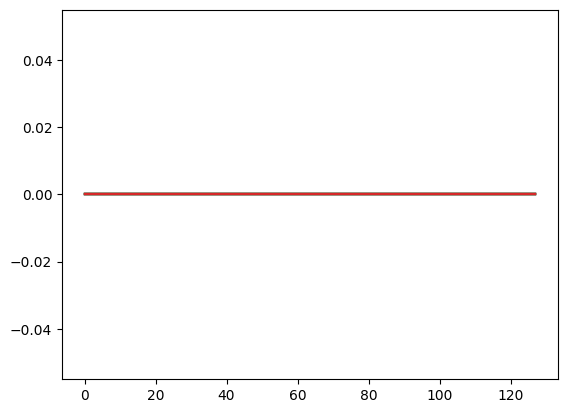

In [11]:
transcription = pretty_midi.PrettyMIDI(midis[0])
for note in transcription.instruments[0].notes:
    print(note.end-note.start)
plt.plot(transcription.get_piano_roll(1))

In [12]:
def load_audio(path):
    audio_tensors = []
    waveform, _ = torchaudio.load(path)
    return waveform

def load_roll(path, frames):
    transcription = pretty_midi.PrettyMIDI(path)
    roll = turn_transcription_into_roll(transcription, frames)

    return torch.from_numpy(roll).float()


# SISNR

In [13]:
def expand(x, out_size=44100*4, step=4410):
    output_tensor = torch.zeros((5, out_size))
    for i in range(x.shape[1]):  # Iterate over the second dimension
        start_idx = i * step
        end_idx = start_idx + step
        output_tensor[:, start_idx:end_idx] = x[:, i].unsqueeze(1)
    return output_tensor

def compress(x, original_shape=(5, 40), step=4410):
    """
    Compresses a tensor from a larger size to its original smaller size by averaging blocks of values.
    
    Args:
    - x (Tensor): The input tensor to be compressed, expected to have the shape (5, 44100) or similar.
    - original_shape (tuple): The shape of the output tensor, default is (5, 40).
    - step (int): The size of the block to average over, default is 4410.
    
    Returns:
    - Tensor: The compressed tensor with shape specified by `original_shape`.
    """
    output_tensor = torch.zeros(original_shape)
    for i in range(original_shape[1]):  # Iterate over the second dimension of the target shape
        start_idx = i * step
        end_idx = start_idx + step
        # Take the mean of each block and assign it to the corresponding position in the output tensor
        output_tensor[:, i] = x[:, start_idx:end_idx].mean(dim=1)
    return output_tensor

In [14]:
class AudioData:
    def __init__(self, audio):
        self.audio = audio

In [15]:
def find_best(mixture_tensor_, drum_tensor_):
    with torch.no_grad():
        shape = (5,40)
        solution = torch.zeros(shape)
        proposed = expand(solution).unsqueeze(0)
        
        sep = model(mixture_tensor_.to(model.device), proposed.to(model.device))
        loss = model.compute_loss(sep, drum_tensor_).item()

        for i in range(40):
            for c in range(5):
                candidate = solution.detach().clone()
                candidate[c, i] = 1

                candidate_expand = expand(candidate).unsqueeze(0) 

                sep = model(mixture_tensor_.to(model.device), candidate_expand.to(model.device))
                new_loss = model.compute_loss(sep.to(model.device), drum_tensor_.to(model.device)).item()

                if new_loss < loss:
                    loss = new_loss
                    solution = candidate

        return candidate

In [16]:
def calculate_precision_recall_torch(transcription, prediction):
    TPs = torch.sum((transcription == 1) & (prediction == 1), dim=1)
    FPs = torch.sum((transcription == 0) & (prediction == 1), dim=1)
    FNs = torch.sum((transcription == 1) & (prediction == 0), dim=1)

    precision = TPs.float() / (TPs + FPs).float()
    recall = TPs.float() / (TPs + FNs).float()

    # Handle potential division by zero for precision and recall
    precision[torch.isnan(precision)] = 0
    recall[torch.isnan(recall)] = 0

    return precision, recall

In [17]:
def calculate_f_measure(precision, recall, beta=1):
    """
    Calculate the F-measure for each class and the average F-measure.

    Parameters:
    - precision: Tensor of precision values per class.
    - recall: Tensor of recall values per class.
    - beta: Weight of recall in the harmonic mean.

    Returns:
    - f_measure: Tensor of F-measure for each class.
    - average_f_measure: Scalar, average F-measure across all classes.
    """
    numerator = (1 + beta**2) * precision * recall
    denominator = (beta**2 * precision) + recall

    # Avoid division by zero
    denominator[denominator == 0] = 1

    f_measure = numerator / denominator

    # Handle potential NaN values
    f_measure[torch.isnan(f_measure)] = 0

    average_f_measure = torch.mean(f_measure)

    return f_measure, average_f_measure

In [18]:
name = 'epoch_200'


out_dir = f"D:/Github/phd-drum-sep/model-as-adt/results_conv_{name}/"
try:
    os.mkdir(out_dir)
except:
    pass


out_dir = f"D:/Github/phd-drum-sep/model-as-adt/results_conv_{name}/adt/"
try:
    os.mkdir(out_dir)
except:
    pass


model = DrumConvTasnet.load_from_checkpoint(f'D:/Github/phd-drum-sep/analysis/conv_tasnet_model_analysis/checkpoint/{name}.ckpt')
model = model.eval()

results = museval.EvalStore(frames_agg='median', tracks_agg='median')
for track in tqdm(all_tracks):

    mixture_tensor = load_audio(track.mix_path).unsqueeze(0).to(model.device)
    snippet_length = (mixture_tensor.shape[2] // (44100 * 4)) * (44100 * 4)
    mixture_tensor = mixture_tensor[:,:, :snippet_length]

    drum_tensor = load_audio(track.drum_path).unsqueeze(0)
    drum_tensor = torch.cat([drum_tensor, drum_tensor], dim=1).to(model.device)
    drum_tensor = drum_tensor[:,:, :snippet_length]

    shape = mixture_tensor.shape[2]
    roll_tensor = load_roll(track.midi_path, shape).unsqueeze(0).to(model.device)
    roll_tensor = roll_tensor[:,:, :snippet_length]

    proposed_answers = []
    
    device = mixture_tensor.device
    batch, channels, length = mixture_tensor.shape
    chunk_len = int(44100 * 4)

    for start in tqdm(range(0, length, chunk_len)):
        end = start + chunk_len
        answer = find_best(mixture_tensor[:,:,start:end], drum_tensor[:,:, start:end])
        proposed_answers.append(answer)

    expanded = [expand(p).unsqueeze(0) for p in proposed_answers]
    # expanded = torch.cat(expanded, dim=2)
    pres = [[],[],[],[],[]]
    recs = [[],[],[],[],[]]
    for idx, val in enumerate(expanded):
        segment = 44100 * 4
        start = idx * segment
        end = start + segment
        slice = roll_tensor[:, :, start:end].to(model.device).squeeze(0)
        pred = val.to(model.device).squeeze(0)
        pre, rec = calculate_precision_recall_torch(slice, pred)
    
        for drum in range(5):
            pres[drum].append(pre[drum].unsqueeze(0))
            recs[drum].append(rec[drum].unsqueeze(0))
            
    for p in range(len(pres)):
        for q in range(len(pres[p])):
            try:
                pres[p][q] = pres[p][q].item()
            except:
                pass
                
    for p in range(len(recs)):
        for q in range(len(recs[p])):
            try:
                recs[p][q] = recs[p][q].item()
            except:
                pass

    try:
        os.mkdir(f'{out_dir}{track.name}')
    except:
        pass
    
    df = pd.DataFrame(pres)
    df = df.T
    df.to_csv(f'{out_dir}{track.name}/precision.csv')

    df = pd.DataFrame(recs)
    df = df.T
    df.to_csv(f'{out_dir}{track.name}/recall.csv')

    for idx, val in enumerate(proposed_answers):
        adf = pd.DataFrame(val.numpy())
        adf.to_csv(f'{out_dir}{track.name}/{idx}.csv')
    

C:\Python311\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.2
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [6:46:18<00:00, 1059.94s/it]
